# Perform A/B Test using REST Endpoints

You can test and deploy new models behind a single SageMaker Endpoint with a concept called “production variants.” These variants can differ by hardware (CPU/GPU), by data (comedy/drama movies), or by region (US West or Germany North). You can shift traffic between the models in your endpoint for canary rollouts and blue/green deployments. You can split traffic for A/B tests. And you can configure your endpoint to automatically scale your endpoints out or in based on a given metric like requests per second. As more requests come in, SageMaker will automatically scale the model prediction API to meet the demand.

<img src="img/model_ab.png" width="80%" align="left">

We can use traffic splitting to direct subsets of users to different model variants for the purpose of comparing and testing different models in live production. The goal is to see which variants perform better. Often, these tests need to run for a long period of time (weeks) to be statistically significant. The figure shows 2 different recommendation models deployed using a random 50-50 traffic split between the 2 variants.

In [1]:
!pip install -q --upgrade pip
!pip install -q wrapt --upgrade --ignore-installed
!pip install -q tensorflow==2.1.0
!pip install -q transformers==2.8.0

ERROR: astroid 2.3.3 has requirement wrapt==1.11.*, but you'll have wrapt 1.12.1 which is incompatible.


In [2]:
!pip install -q sagemaker==1.69.0
!pip install -q sagemaker-experiments==0.1.13

# Restart the Kernel to Pick Up New SageMaker Python SDK Library

In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

# ^^ Restart ^^ the Kernel to Pick Up New SageMaker Python SDK Library

In [1]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)
cw = boto3.Session().client("cloudwatch")

# Clean Up Previous Endpoints to Make Room for New Endpoints!

In [2]:
%store -r autopilot_endpoint_name

In [3]:
print(autopilot_endpoint_name)

automl-dm-ep-25-16-51-33


In [4]:
try:
    sm.delete_endpoint(
        EndpointName=autopilot_endpoint_name
    )
    print('Endpoint has been deleted!')
except:
    print('Endpoint has already been deleted.  This is good!')

Endpoint has already been deleted.  This is good!


In [5]:
%store -r training_job_name

In [6]:
print(training_job_name)

tensorflow-training-2020-07-25-18-45-23-722


# Copy the Model to the Notebook

In [7]:
!aws s3 cp s3://$bucket/$training_job_name/output/model.tar.gz ./model.tar.gz

download: s3://sagemaker-us-west-2-140773038493/tensorflow-training-2020-07-25-18-45-23-722/output/model.tar.gz to ./model.tar.gz


In [8]:
!tar -xvzf ./model.tar.gz

tensorflow/
tensorflow/saved_model/
tensorflow/saved_model/0/
tensorflow/saved_model/0/assets/
tensorflow/saved_model/0/variables/
tensorflow/saved_model/0/variables/variables.index
tensorflow/saved_model/0/variables/variables.data-00000-of-00001
tensorflow/saved_model/0/saved_model.pb
tensorboard/
transformers/
transformers/fine-tuned/
transformers/fine-tuned/config.json
transformers/fine-tuned/tf_model.h5
metrics/
metrics/confusion_matrix.png


# Show the Prediction Signature

In [9]:
!saved_model_cli show --all --dir ./tensorflow/saved_model/0/

2020-07-25 19:31:25.778545: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.0/lib64:/usr/local/cuda-10.0/extras/CUPTI/lib64:/usr/local/cuda-10.0/lib:/usr/local/cuda-10.0/efa/lib:/opt/amazon/efa/lib:/opt/amazon/efa/lib64:/usr/lib64/openmpi/lib/:/usr/local/lib:/usr/lib:/usr/local/mpi/lib:/lib/:/usr/lib64/openmpi/lib/:/usr/local/lib:/usr/lib:/usr/local/mpi/lib:/lib/:/usr/lib64/openmpi/lib/:/usr/local/lib:/usr/lib:/usr/local/mpi/lib:/lib/:
2020-07-25 19:31:25.778628: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.0/lib64:/usr/local/cuda-10.0/extras/CUPTI/lib64:/usr/local/cuda-10.0/lib:/usr/local/cuda-10.0/ef

# Create Variant A Model From the Training Job in a Previous Section

Notes:
* `primary_container_image` is required because the inference and training images are different.
* By default, the training image will be used, so we need to override it.  
* See https://github.com/aws/sagemaker-python-sdk/issues/1379
* This variant requires the Elastic Inference image since we are using Elastic Inference
* If you are not using a US-based region, you may need to adapt the container image to your current region using the following table:

https://docs.aws.amazon.com/deep-learning-containers/latest/devguide/deep-learning-containers-images.html

In [10]:
import time
timestamp = '{}'.format(int(time.time()))

model_a_name = '{}-{}-{}'.format(training_job_name, 'var-a', timestamp)

sess.create_model_from_job(name=model_a_name,
                           training_job_name=training_job_name,
                           role=role,
                           primary_container_image='763104351884.dkr.ecr.{}.amazonaws.com/tensorflow-inference:2.1.0-cpu-py36-ubuntu18.04'.format(region))

'tensorflow-training-2020-07-25-18-45-23-722-var-a-1595705491'

# Create Variant B Model From the Training Job in a Previous Section
Notes:
* This is the same underlying model as variant A, but does not use an attached Elastic Inference Adapter (EIA).
* `primary_container_image` is required because the inference and training images are different.
* By default, the training image will be used, so we need to override it.  
* See https://github.com/aws/sagemaker-python-sdk/issues/1379
* If you are not using a US-based region, you may need to adapt the container image to your current region using the following table:

https://docs.aws.amazon.com/deep-learning-containers/latest/devguide/deep-learning-containers-images.html

In [11]:
model_b_name = '{}-{}-{}'.format(training_job_name, 'var-b', timestamp)

sess.create_model_from_job(name=model_b_name,
                           training_job_name=training_job_name,
                           role=role,
                           primary_container_image='763104351884.dkr.ecr.{}.amazonaws.com/tensorflow-inference:2.1.0-cpu-py36-ubuntu18.04'.format(region))

'tensorflow-training-2020-07-25-18-45-23-722-var-b-1595705491'

# Canary Rollouts and A/B Testing

Canary rollouts are used to release new models safely to only a small subset of users such as 5%. They are useful if you want to test in live production without affecting the entire user base. Since the majority of traffic goes to the existing model, the cluster size of the canary model can be relatively small since it’s only receiving 5% traffic.

Instead of `deploy()`, we can create an `Endpoint Configuration` with multiple variants for canary rollouts and A/B testing.

In [12]:
from sagemaker.session import production_variant

timestamp = '{}'.format(int(time.time()))

endpoint_config_name = '{}-{}'.format(training_job_name, timestamp)

variantA = production_variant(model_name=model_a_name,
                              instance_type="ml.m5.large",
                              initial_instance_count=1,
                              variant_name='VariantA',
                              initial_weight=50)

variantB = production_variant(model_name=model_b_name,
                              instance_type="ml.m5.large",
                              initial_instance_count=1,
                              variant_name='VariantB',
                              initial_weight=50)

endpoint_config = sm.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[variantA, variantB]
)

In [13]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpointConfig/{}">REST Endpoint Configuration</a></b>'.format(region, endpoint_config_name)))


In [14]:
endpoint_name = '{}-{}'.format(training_job_name, timestamp)

endpoint_response = sm.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)

# Store Endpoint Name for Next Notebook(s)

In [15]:
model_ab_endpoint = endpoint_name

In [16]:
%store model_ab_endpoint

Stored 'model_ab_endpoint' (str)


# Track the Deployment Within our Experiment

In [17]:
%store -r experiment_name

In [18]:
print(experiment_name)

Amazon-Customer-Reviews-BERT-Experiment-1595702720


In [19]:
%store -r trial_name

In [20]:
print(trial_name)

trial-1595702720


In [21]:
from smexperiments.trial import Trial

timestamp = '{}'.format(int(time.time()))

trial = Trial.load(trial_name=trial_name)
print(trial)

Trial(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7fd820c33fd0>,trial_name='trial-1595702720',trial_arn='arn:aws:sagemaker:us-west-2:140773038493:experiment-trial/trial-1595702720',display_name='trial-1595702720',experiment_name='Amazon-Customer-Reviews-BERT-Experiment-1595702720',creation_time=datetime.datetime(2020, 7, 25, 18, 45, 20, 675000, tzinfo=tzlocal()),created_by={},last_modified_time=datetime.datetime(2020, 7, 25, 19, 24, 39, 747000, tzinfo=tzlocal()),last_modified_by={},response_metadata={'RequestId': '0a869656-35ac-4993-98f6-0c543071aaaa', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '0a869656-35ac-4993-98f6-0c543071aaaa', 'content-type': 'application/x-amz-json-1.1', 'content-length': '326', 'date': 'Sat, 25 Jul 2020 19:31:32 GMT'}, 'RetryAttempts': 0})


In [22]:
from smexperiments.tracker import Tracker

tracker_deploy = Tracker.create(display_name='deploy', 
                                sagemaker_boto_client=sm)

deploy_trial_component_name = tracker_deploy.trial_component.trial_component_name
print('Deploy trial component name {}'.format(deploy_trial_component_name))

Deploy trial component name TrialComponent-2020-07-25-193132-uyza


# Attach the `deploy` Trial Component and Tracker as a Component to the Trial

In [23]:
trial.add_trial_component(tracker_deploy.trial_component)

# Track the Endpoint Name

In [24]:
tracker_deploy.log_parameters({
    'endpoint_name': endpoint_name,
})

# must save after logging
tracker_deploy.trial_component.save()

TrialComponent(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7fd803adb3c8>,trial_component_name='TrialComponent-2020-07-25-193132-uyza',display_name='deploy',trial_component_arn='arn:aws:sagemaker:us-west-2:140773038493:experiment-trial-component/trialcomponent-2020-07-25-193132-uyza',response_metadata={'RequestId': 'e4ed7db0-19a2-42e4-a8ac-213c8cb4924b', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'e4ed7db0-19a2-42e4-a8ac-213c8cb4924b', 'content-type': 'application/x-amz-json-1.1', 'content-length': '129', 'date': 'Sat, 25 Jul 2020 19:31:32 GMT'}, 'RetryAttempts': 0},parameters={'endpoint_name': 'tensorflow-training-2020-07-25-18-45-23-722-1595705492'},input_artifacts={},output_artifacts={})

In [25]:
from sagemaker.analytics import ExperimentAnalytics

lineage_table = ExperimentAnalytics(
    sagemaker_session=sess,
    experiment_name=experiment_name,
    metric_names=['validation:accuracy'],
    sort_by="CreationTime",
    sort_order="Ascending",
)

lineage_df = lineage_table.dataframe()
lineage_df.shape

(4, 43)

In [26]:
lineage_df

,TrialComponentName,DisplayName,balance_dataset,max_seq_length,test_split_percentage,train_split_percentage,validation_split_percentage,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,...,use_amp,use_xla,validation_batch_size,validation_steps,validation:accuracy - Min,validation:accuracy - Max,validation:accuracy - Avg,validation:accuracy - StdDev,validation:accuracy - Last,validation:accuracy - Count
0,TrialComponent-2020-07-25-184520-myut,prepare,False,128.0,0.05,0.9,0.05,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tensorflow-training-2020-07-25-18-45-23-722-aw...,train,NaN,128.0,NaN,NaN,NaN,arn:aws:sagemaker:us-west-2:140773038493:train...,763104351884.dkr.ecr.us-west-2.amazonaws.com/t...,1.0,...,true,true,128.0,50.0,0.643,0.643,0.643,0.0,0.643,1.0
2,TrialComponent-2020-07-25-190221-rkvi,optimize-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TrialComponent-2020-07-25-192439-ntgs,optimize-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">REST Endpoint</a></b>'.format(region, endpoint_name)))


# _Wait Until the ^^ Endpoint ^^ is Deployed_

In [28]:
waiter = sm.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)

# Simulate a Prediction from an Application

## Setup the Request Handler to Convert Raw Text into BERT Tokens

In [29]:
class RequestHandler(object):
    import json
    
    def __init__(self, tokenizer, max_seq_length):
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

    def __call__(self, instances):
        transformed_instances = []

        for instance in instances:
            encode_plus_tokens = tokenizer.encode_plus(instance,
                                                       pad_to_max_length=True,
                                                       max_length=self.max_seq_length)

            input_ids = encode_plus_tokens['input_ids']
            input_mask = encode_plus_tokens['attention_mask']
            segment_ids = [0] * self.max_seq_length

            transformed_instance = {"input_ids": input_ids, 
                                    "input_mask": input_mask, 
                                    "segment_ids": segment_ids}

            transformed_instances.append(transformed_instance)

        transformed_data = {"instances": transformed_instances}

        return json.dumps(transformed_data)

## Setup the Response Handler to Convert the BERT Response into Our Predicted Classes

In [30]:
class ResponseHandler(object):
    import json
    import tensorflow as tf
    
    def __init__(self, classes):
        self.classes = classes
    
    def __call__(self, response, accept_header):
        import tensorflow as tf

        response_body = response.read().decode('utf-8')

        response_json = json.loads(response_body)

        log_probabilities = response_json["predictions"]

        predicted_classes = []

        # Convert log_probabilities => softmax (all probabilities add up to 1) => argmax (final prediction)
        for log_probability in log_probabilities:
            softmax = tf.nn.softmax(log_probability)    
            predicted_class_idx = tf.argmax(softmax, axis=-1, output_type=tf.int32)
            predicted_class = self.classes[predicted_class_idx]
            predicted_classes.append(predicted_class)

        return predicted_classes

## Instantiate the Request/Response Handler Classes Above

In [31]:
import json
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

request_handler = RequestHandler(tokenizer=tokenizer,
                                 max_seq_length=128)

response_handler = ResponseHandler(classes=[1, 2, 3, 4, 5])

INFO:transformers.file_utils:PyTorch version 1.5.0 available.
INFO:transformers.file_utils:TensorFlow version 2.1.0 available.
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/ec2-user/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


## Instantiate the Predictor with our Endpoint

In [32]:
from sagemaker.tensorflow.serving import Predictor

predictor = Predictor(endpoint_name=endpoint_name,
                      sagemaker_session=sess,
                      serializer=request_handler,
                      deserializer=response_handler,
                      content_type='application/json',
                      model_name='saved_model',
                      model_version=0)

# Predict the `star_rating` with `review_body` Samples from our TSV's

In [33]:
import csv

df_reviews = pd.read_csv('./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz', 
                                delimiter='\t', 
                                quoting=csv.QUOTE_NONE,
                                compression='gzip')
df_sample_reviews = df_reviews[['review_body', 'star_rating']].sample(n=50)
df_sample_reviews = df_sample_reviews.reset_index()
df_sample_reviews.shape

(50, 3)

In [34]:
import pandas as pd

def predict(review_body):
    return predictor.predict([review_body])[0]

df_sample_reviews['predicted_class'] = df_sample_reviews['review_body'].map(predict)
df_sample_reviews.head(5)

,index,review_body,star_rating,predicted_class
0,78854,Love it! Takes my pictures to a while new leve...,5,5
1,60453,I've used Quicken with great success for many ...,2,5
2,73723,Downloaded it tried to use it and POOF ABSOLUT...,1,5
3,82966,1st time I used an internet downloaded softwar...,5,5
4,47474,‎Buyer Beware:<br />On July 15th. I ordered Mi...,1,5


# Predict the `star_rating` with Ad Hoc `review_body` Samples

In [35]:
import tensorflow as tf
import json
    
reviews = ["This is great!", 
           "This is not good."]

predicted_classes = predictor.predict(reviews)

for predicted_class, review in zip(predicted_classes, reviews):
    print('[Predicted Star Rating: {}]'.format(predicted_class), review)

[Predicted Star Rating: 5] This is great!
[Predicted Star Rating: 5] This is not good.


# Review the REST Endpoint Performance Metrics in CloudWatch

In [36]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">REST Endpoint Performance Metrics</a></b>'.format(region, endpoint_name)))


# Review the REST Endpoint Performance Metrics in a Dataframe

Amazon SageMaker emits metrics such as Latency and Invocations (full list of metrics [here](https://alpha-docs-aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html)) for each variant in Amazon CloudWatch. Let’s query CloudWatch to get the InvocationsPerVariant to show how invocations are split across variants.

In [37]:
from datetime import datetime, timedelta

import boto3
import pandas as pd

def get_invocation_metrics_for_endpoint_variant(endpoint_name,
                                                namespace_name,
                                                metric_name,
                                                variant_name,
                                                start_time,
                                                end_time):
    metrics = cw.get_metric_statistics(
        Namespace=namespace_name,
        MetricName=metric_name,
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=["Sum"],
        Dimensions=[
            {
                "Name": "EndpointName",
                "Value": endpoint_name
            },
            {
                "Name": "VariantName",
                "Value": variant_name
            }
        ]
    )

    if metrics['Datapoints']:
        return pd.DataFrame(metrics["Datapoints"])\
                .sort_values("Timestamp")\
                .set_index("Timestamp")\
                .drop("Unit", axis=1)\
                .rename(columns={"Sum": variant_name})
    else:
        return pd.DataFrame()


def plot_endpoint_metrics_for_variants(endpoint_name,
                                       namespace_name,
                                       metric_name,
                                       start_time=None):
    start_time = start_time or datetime.now() - timedelta(minutes=60)
    end_time = datetime.now()

    metrics_variantA = get_invocation_metrics_for_endpoint_variant(endpoint_name=endpoint_name, 
                                                                   namespace_name=namespace_name,
                                                                   metric_name=metric_name,
                                                                   variant_name=variantA["VariantName"], 
                                                                   start_time=start_time, 
                                                                   end_time=end_time)
    
    metrics_variantB = get_invocation_metrics_for_endpoint_variant(endpoint_name=endpoint_name,
                                                                   namespace_name=namespace_name,
                                                                   metric_name=metric_name,                                                                   
                                                                   variant_name=variantB["VariantName"], 
                                                                   start_time=start_time, 
                                                                   end_time=end_time)

    metrics_variants = metrics_variantA.join(metrics_variantB, how="outer")
    metrics_variants.plot()

# Show the Metrics for Each Variant
If you see `Metrics not yet available`, please be patient as metrics may take a few mins to appear in CloudWatch.

Also, make sure the predictions ran successfully above.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


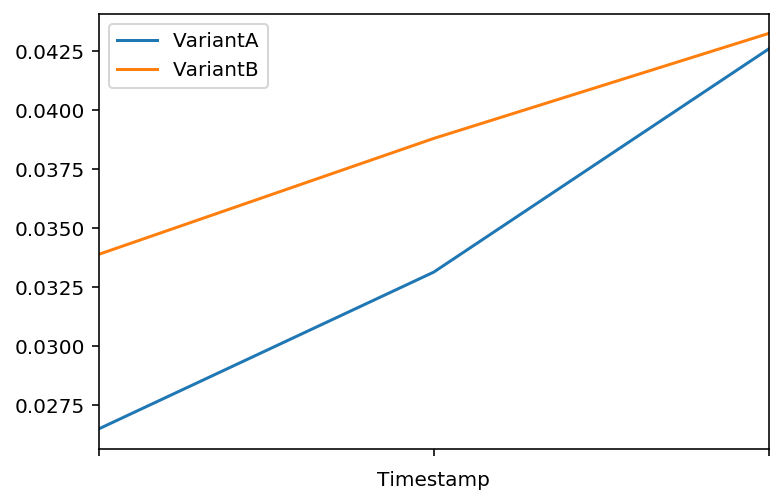

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(20)
plot_endpoint_metrics_for_variants(endpoint_name=endpoint_name,
                                   namespace_name='/aws/sagemaker/Endpoints',
                                   metric_name='CPUUtilization')

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(5)
plot_endpoint_metrics_for_variants(endpoint_name=endpoint_name,
                                   namespace_name='AWS/SageMaker',                                   
                                   metric_name='Invocations')

TypeError: no numeric data to plot

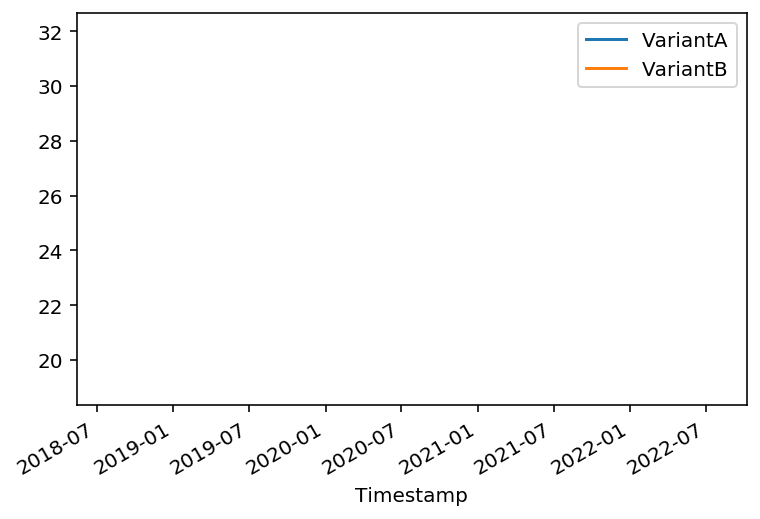

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(5)
plot_endpoint_metrics_for_variants(endpoint_name=endpoint_name,
                                   namespace_name='AWS/SageMaker',                                   
                                   metric_name='InvocationsPerInstance')

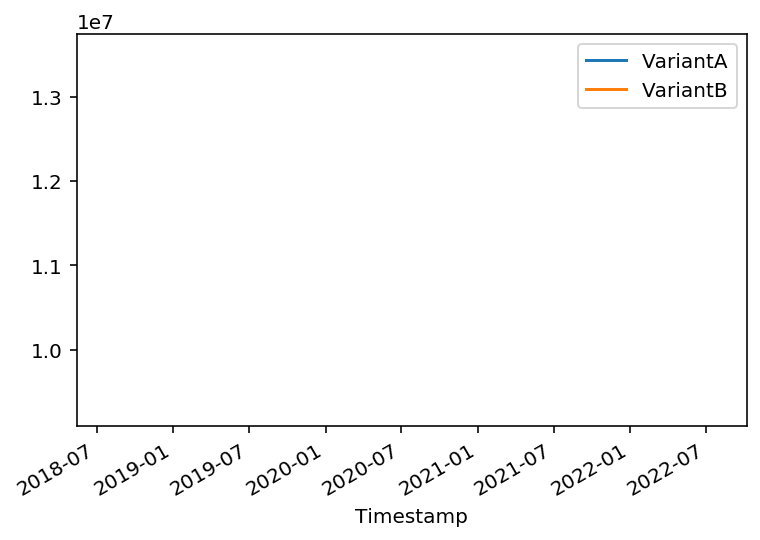

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(5)
plot_endpoint_metrics_for_variants(endpoint_name=endpoint_name,
                                   namespace_name='AWS/SageMaker',                                   
                                   metric_name='ModelLatency')

# Shift All Traffic to Variant B
_**No downtime** occurs during this traffic-shift activity._

This may take a few minutes.  Please be patient.

In [42]:
updated_endpoint_config = [
    {
        'VariantName': variantA['VariantName'],
        'DesiredWeight': 0,
    },
    {
        'VariantName': variantB['VariantName'],
        'DesiredWeight': 100,
    }
]

In [43]:
sm.update_endpoint_weights_and_capacities(
    EndpointName=endpoint_name,
    DesiredWeightsAndCapacities=updated_endpoint_config
)

{'EndpointArn': 'arn:aws:sagemaker:us-west-2:140773038493:endpoint/tensorflow-training-2020-07-25-18-45-23-722-1595705492',
 'ResponseMetadata': {'RequestId': '96da5294-4cba-469b-b71e-981511081a45',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '96da5294-4cba-469b-b71e-981511081a45',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '122',
   'date': 'Sat, 25 Jul 2020 19:39:27 GMT'},
  'RetryAttempts': 0}}

In [44]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">REST Endpoint</a></b>'.format(region, endpoint_name)))


# _Wait for the ^^ Endpoint Update ^^ to Complete Above_
This may take a few minutes.  Please be patient.

In [45]:
waiter = sm.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)

# Run Some More Predictions

In [46]:
import pandas as pd

def predict(review_body):
    return predictor.predict([review_body])[0]

df_sample_reviews['predicted_class'] = df_sample_reviews['review_body'].map(predict)
df_sample_reviews

,index,review_body,star_rating,predicted_class
0,78854,Love it! Takes my pictures to a while new leve...,5,5
1,60453,I've used Quicken with great success for many ...,2,5
2,73723,Downloaded it tried to use it and POOF ABSOLUT...,1,5
3,82966,1st time I used an internet downloaded softwar...,5,5
4,47474,‎Buyer Beware:<br />On July 15th. I ordered Mi...,1,5
5,74092,Lot of bugs to work out yet. What if tool does...,2,5
6,63455,Turbo tax is so easy and fast! Got refund back...,5,5
7,9902,Fast and easy to do the taxes. Did miss a few...,4,5
8,71315,I've recommended AVAST to most of my friends. ...,5,5
9,78680,We installed on all our computers in the anima...,5,5


# Show the Metrics for Each Variant
If you see `Metrics not yet available`, please be patient as metrics may take a few mins to appear in CloudWatch.

Also, make sure the predictions ran successfully above.

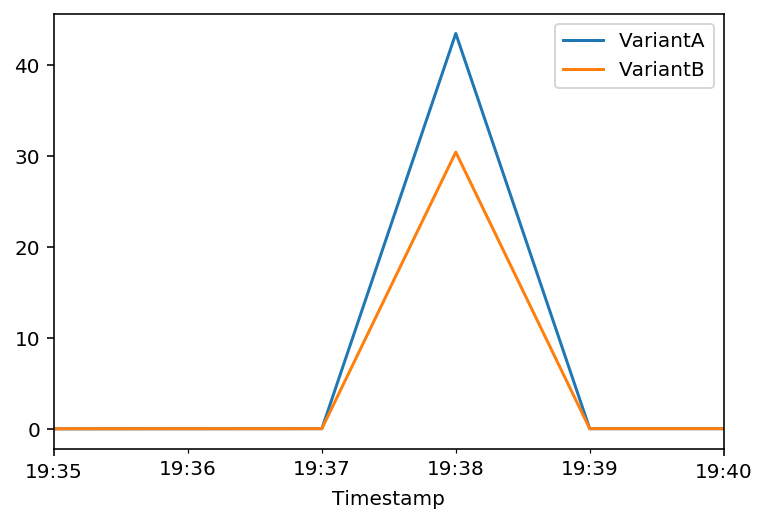

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(20)
plot_endpoint_metrics_for_variants(endpoint_name=endpoint_name,
                                   namespace_name='/aws/sagemaker/Endpoints',
                                   metric_name='CPUUtilization')

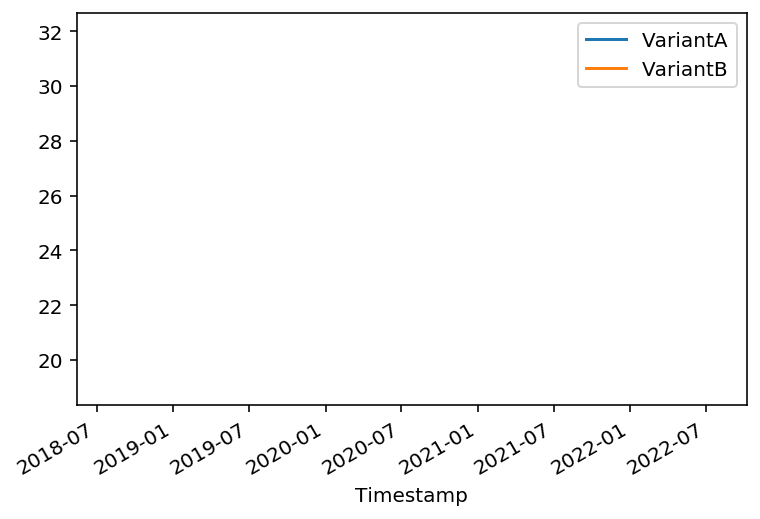

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(5)
plot_endpoint_metrics_for_variants(endpoint_name=endpoint_name,
                                   namespace_name='AWS/SageMaker',                                   
                                   metric_name='Invocations')

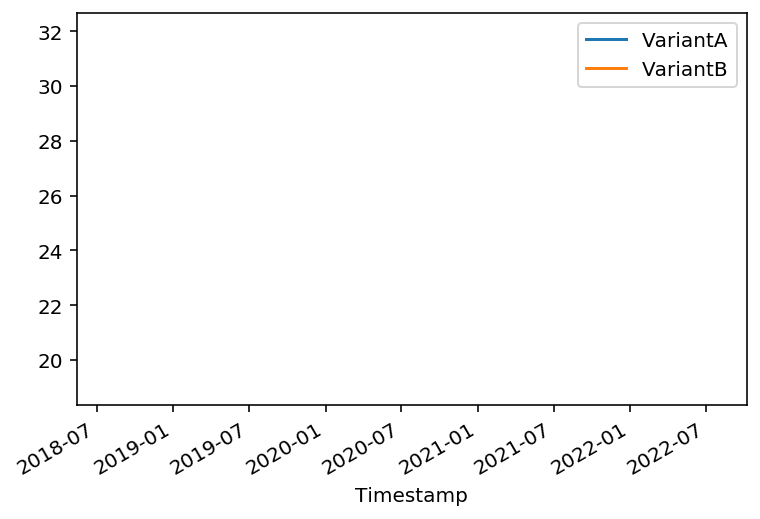

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(5)
plot_endpoint_metrics_for_variants(endpoint_name=endpoint_name,
                                   namespace_name='AWS/SageMaker',                                   
                                   metric_name='InvocationsPerInstance')

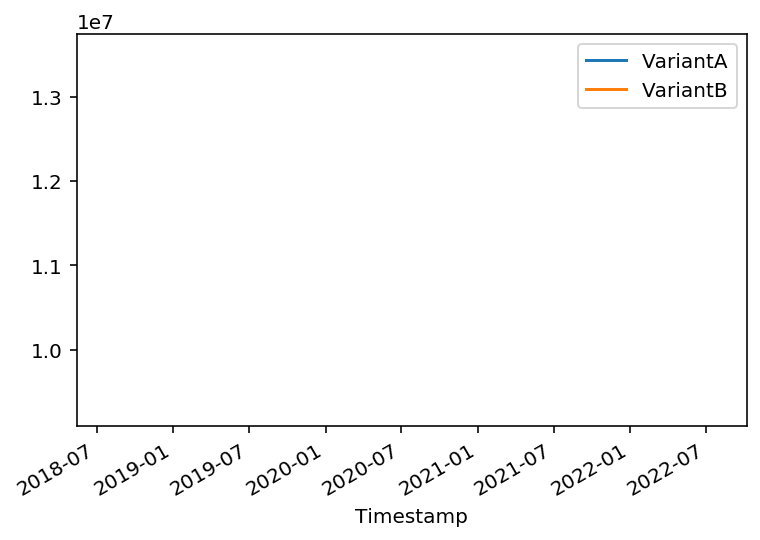

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(5)
plot_endpoint_metrics_for_variants(endpoint_name=endpoint_name,
                                   namespace_name='AWS/SageMaker',                                   
                                   metric_name='ModelLatency')

# Remove Variant A to Reduce Cost
Modify the Endpoint Configuration to only use variant B.

_**No downtime** occurs during this scale-down activity._

This may take a few mins.  Please be patient.

In [51]:
import time
timestamp = '{}'.format(int(time.time()))

updated_endpoint_config_name = '{}-{}'.format(training_job_name, timestamp)

updated_endpoint_config = sm.create_endpoint_config(
    EndpointConfigName=updated_endpoint_config_name,
    ProductionVariants=[
        {
         'VariantName': variantB['VariantName'],
         'ModelName': model_b_name,  # Only specify variant B to remove variant A
         'InstanceType':'ml.m5.large',
         'InitialInstanceCount': 1,
         'InitialVariantWeight': 100
        }
    ])

In [52]:
sm.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=updated_endpoint_config_name
)

{'EndpointArn': 'arn:aws:sagemaker:us-west-2:140773038493:endpoint/tensorflow-training-2020-07-25-18-45-23-722-1595705492',
 'ResponseMetadata': {'RequestId': '32e7dd71-cd2c-4484-8c69-1f6f57cf03b0',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '32e7dd71-cd2c-4484-8c69-1f6f57cf03b0',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '122',
   'date': 'Sat, 25 Jul 2020 19:41:52 GMT'},
  'RetryAttempts': 0}}

# _If You See An ^^ Error ^^ Above, Please Wait Until the Endpoint is Updated_

In [53]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">REST Endpoint</a></b>'.format(region, endpoint_name)))


# _Wait for the ^^ Endpoint Update ^^ to Complete Above_
This may take a few minutes.  Please be patient.

In [54]:
waiter = sm.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)

# Run Some More Predictions

In [55]:
import pandas as pd

def predict(review_body):
    return predictor.predict([review_body])[0]

df_sample_reviews['predicted_class'] = df_sample_reviews['review_body'].map(predict)
df_sample_reviews

,index,review_body,star_rating,predicted_class
0,78854,Love it! Takes my pictures to a while new leve...,5,5
1,60453,I've used Quicken with great success for many ...,2,5
2,73723,Downloaded it tried to use it and POOF ABSOLUT...,1,5
3,82966,1st time I used an internet downloaded softwar...,5,5
4,47474,‎Buyer Beware:<br />On July 15th. I ordered Mi...,1,5
5,74092,Lot of bugs to work out yet. What if tool does...,2,5
6,63455,Turbo tax is so easy and fast! Got refund back...,5,5
7,9902,Fast and easy to do the taxes. Did miss a few...,4,5
8,71315,I've recommended AVAST to most of my friends. ...,5,5
9,78680,We installed on all our computers in the anima...,5,5


# Show the Metrics for Each Variant
If you see `Metrics not yet available`, please be patient as metrics may take a few mins to appear in CloudWatch.

Also, make sure the predictions ran successfully above.

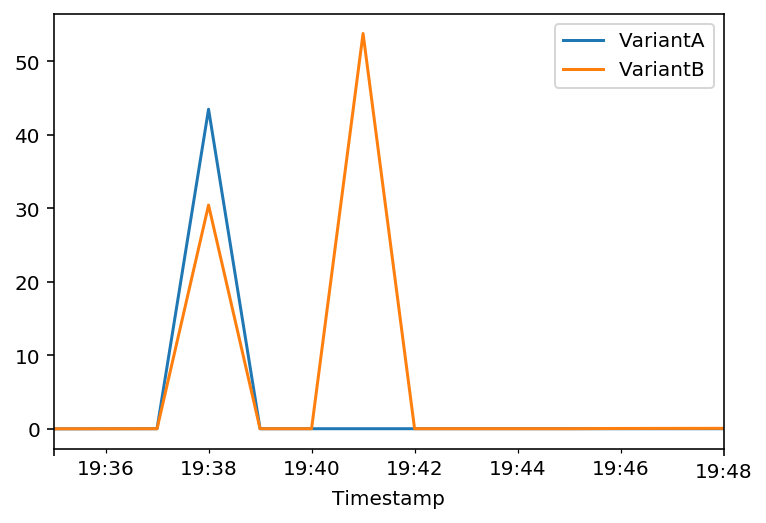

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(20)
plot_endpoint_metrics_for_variants(endpoint_name=endpoint_name,
                                   namespace_name='/aws/sagemaker/Endpoints',
                                   metric_name='CPUUtilization')

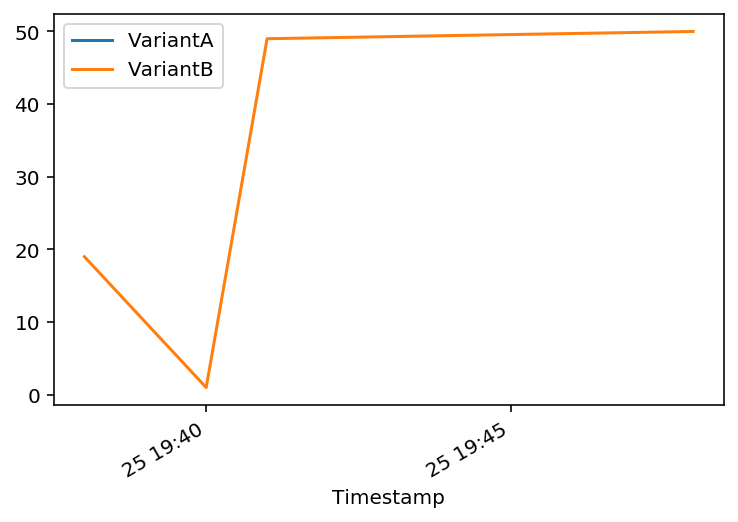

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(5)
plot_endpoint_metrics_for_variants(endpoint_name=endpoint_name,
                                   namespace_name='AWS/SageMaker',                                   
                                   metric_name='Invocations')

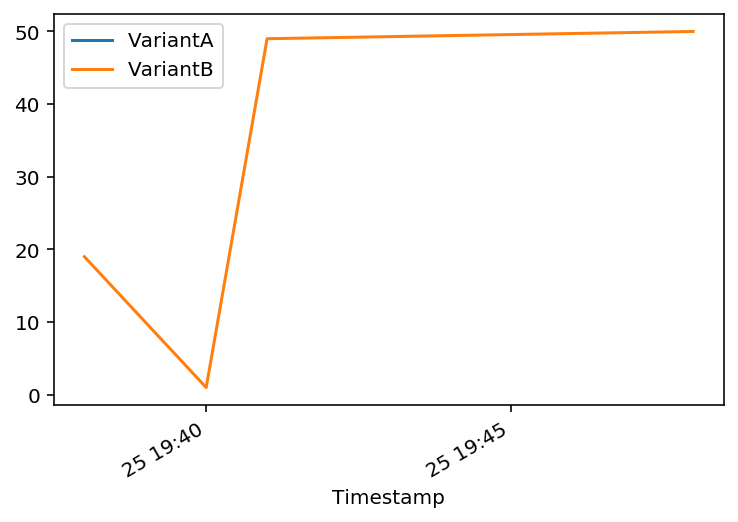

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(5)
plot_endpoint_metrics_for_variants(endpoint_name=endpoint_name,
                                   namespace_name='AWS/SageMaker',                                   
                                   metric_name='InvocationsPerInstance')

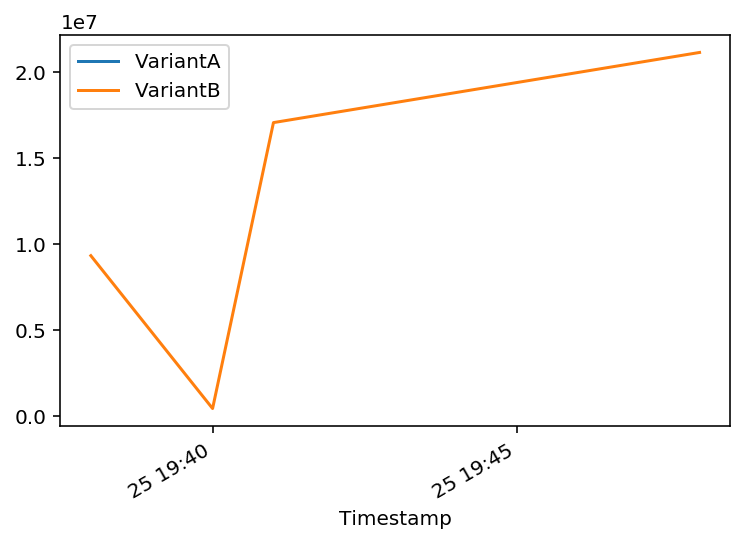

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(5)
plot_endpoint_metrics_for_variants(endpoint_name=endpoint_name,
                                   namespace_name='AWS/SageMaker',                                   
                                   metric_name='ModelLatency')

# Delete Endpoint

In [60]:
# sm.delete_endpoint(
#      EndpointName=endpoint_name
# )

# More Links
* Optimize Cost with TensorFlow and Elastic Inference
https://aws.amazon.com/blogs/machine-learning/optimizing-costs-in-amazon-elastic-inference-with-amazon-tensorflow/

* Using API Gateway with SageMaker Endpoints
https://aws.amazon.com/blogs/machine-learning/creating-a-machine-learning-powered-rest-api-with-amazon-api-gateway-mapping-templates-and-amazon-sagemaker/

In [61]:
%store

Stored variables and their in-db values:
autopilot_endpoint_name                          -> 'automl-dm-ep-25-16-51-33'
balance_dataset                                  -> False
best_candidate_tuning_job_name                   -> 0    tensorflow-training-200725-1924-002-6c632c1c

comprehend_endpoint_arn                          -> 'arn:aws:comprehend:us-west-2:140773038493:documen
experiment_name                                  -> 'Amazon-Customer-Reviews-BERT-Experiment-159570272
header_train_s3_uri                              -> 's3://sagemaker-us-west-2-140773038493/data/amazon
max_seq_length                                   -> 128
model_ab_endpoint                                -> 'tensorflow-training-2020-07-25-18-45-23-722-15957
noheader_train_s3_uri                            -> 's3://sagemaker-us-west-2-140773038493/data/amazon
prepare_trial_component_name                     -> 'TrialComponent-2020-07-25-184520-myut'
processed_test_data_s3_uri                       -> 's3:

In [ ]:
%%javascript
Jupyter.notebook.save_checkpoint();
Jupyter.notebook.session.delete();